# Recommendations Systems
## Assignment 3:  Neural Collaborative Filtering

**By:**  
Group 8

<br><br>

**The goal of this assignment is to:**
- Understand the concept of recommendations based on implicit data which is very common in real life.
- Understand how DL components can be used to implement a collaborative filtering & hybrid approach recommenders.
- Understand pros&cons comparing to other recommender system approaches.
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a link to google colab.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used. 
- You may use Torch/Keras/TF packeges.
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).

**LINKS:**
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>Dataset</a>
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>Repository</a>
- <a href='https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96'>Blog Post Review</a>
<br>

**Google <a href='https://colab.research.google.com/'>Colaboratory</a>**  
        
    This is a great academic tool for students. Instead of installing and running "everything" on your Laptop - which probably will take you a lot of time - you can use Google Colab.  
    Basically, you can use it for all your Python needs.  

**PyTorch <a href='https://pytorch.org/tutorials/beginner/basics/intro.html'>Tutorials</a>**   
    
    Just follow steps 0-7 and you will have the basics skills to understand, build, and run DL recommender models. 

**Keras Kaggle's <a href='https://www.kaggle.com/learn/intro-to-deep-learning'>intro-to-deep-learning</a>**  
    
    This will give you a quick idea of what DL is, and how to utilize it.  
    They're using TensorFlow, while in our MLDL program we're using PyTorch.  




**Grading:**

- Q1 - 20 points - Dataset Preparation
- Q2 - 50 points - Neural Collaborative Filtering
- Q3 - 30 points - Loss Function

`Total: 100`

<br><br><br>

**Prerequisites**

In [ ]:
# !pip install --quiet

**Imports**

In [ ]:
# basic
import os 
import sys
import math
import heapq
import argparse
from time import time
import multiprocessing

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import scipy.sparse as sp

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# visual 3D
from mpl_toolkits import mplot3d

# notebook
from IPython.display import display, HTML


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD


# Keras
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Lambda,Activation
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate
from keras.utils.vis_utils import plot_model
# colab
# from google.colab import drive 

from tqdm.auto import tqdm

**Hide Warnings**

In [ ]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Dataset Preparation (Ingestion)

---


<br><br>

This implementation contains one file for training and two files for testing:   
- ml-1m.train.rating   
- ml-1m.test.rating  
- ml-1m.test.negative   

<br>
(feel free to use visual explanations)
<br>

a. **Explain** the role and structure of each file and how it was created from the original <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>MovieLens 1M rating dataset</a>.

From the READMEFILE:



```
RATINGS FILE DESCRIPTION
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings
```



Dataset

From the given github they provide two processed datasets: MovieLens 1 Million (ml-1m) and Pinterest (pinterest-20).

We will only use the MovieLens dataset.

> train.rating:

* Train file (Positive interactions only - ie that the user interacted with).
* Each Line is a training instance: userID, itemID, rating, timestamp (if have).

* Creation:
From the original MovieLens 1M rating dataset: This dataset was generated explicitly from the ratings.dat from MovieLens 1M dataset - its format: UserID::MovieID::Rating::Timestamp

> test.rating:

* Test file (positive instances).
* Each Line is a testing instance:  userID, itemID, rating, timestamp (if have).

* Creation:
From the original MovieLens 1M rating dataset: this dataset was generated from the same dataset as training.rating, however, for each user only one item was picked, the item with the highest timestamp, the row in ratings.dat with the highest Timestamp value

> test.negative:

* Test file (negative instances - that the user didn't interact with).
* Each line corresponds to the line of test.rating, containing 99 negative samples.
* Each line is in the format: (userID,itemID), negativeItemID1, negativeItemID2 ...
    * The whole Test dataset: first column represents the last item a specific user interacted
with, all the following 99 columns represent all the items the 
user did not interact with, a negative interaction

* Creation:
From the original MovieLens 1M rating dataset: for each user, they took 99 instances that the specific user did not interact with from ratings.dat



b. **Explain** how the training dataset is created.

Training dataset was generated explicitly from ratings.dat of the original MovieLens 1M dataset - with the following format: UserID::MovieID::Rating::Timestamp, including all the ratings besides the last rating of each user (sorted by the timestamp).

c. **Explain** how the test dataset is created.

Test dataset was generated from the same dataset as training.rating, however, for each user only one item (with rating) was picked, the item with the highest timestamp, the row in ratings.dat with the highest Timestamp value. In addition, we have the 99 negative samples corresponding to each user.

#### Data Preperations:

In [ ]:
class Dataset(object):
    '''
    classdocs
    '''

    def __init__(self, path):
        '''
        Constructor
        '''
        self.trainMatrix = self.load_rating_file_as_matrix(path + ".train.rating")
        self.testRatings = self.load_rating_file_as_list(path + ".test.rating")
        self.testNegatives = self.load_negative_file(path + ".test.negative")
        assert len(self.testRatings) == len(self.testNegatives)
        
        self.num_users, self.num_items = self.trainMatrix.shape
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat

In [ ]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

In [ ]:
!mkdir data
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.train.rating -O data/ml-1m.train.rating
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.rating -O data/ml-1m.test.rating
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.negative -O data/ml-1m.test.negative

--2023-01-18 14:33:36--  https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.train.rating
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20982911 (20M) [text/plain]
Saving to: ‘data/ml-1m.train.rating’

data/ml-1m.train.ra 100%[===================>]  20.01M  --.-KB/s    in 0.1s    

2023-01-18 14:33:37 (153 MB/s) - ‘data/ml-1m.train.rating’ saved [20982911/20982911]

--2023-01-18 14:33:37--  https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.rating
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.

In [ ]:
dataset_path = 'data/ml-1m'
dataset = Dataset(dataset_path)
train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.shape
print("Load data done: #user=%d, #item=%d, #train=%d, #test=%d" 
      %(num_users, num_items, len(train), len(testRatings)))

Load data done: #user=6040, #item=3706, #train=994169, #test=6040


<br><br><br>
<br><br><br>
<br><br><br>

## Question 2: Neural Collaborative Filtering 
<br><br>

## a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)

**For each model, use the best hyper-parameters suggested in the neuMF paper.**

<br><br><br><br>
#### Matrix Factorization (MF)  
<br>

In [ ]:
model_MF = None

In [ ]:
def get_MF_model(num_users, num_items, latent_dim):
    # Vanilla Matrix Factorization
    
    # Input layer
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Latent dimension layer
    MF_Embedding_User = Embedding(input_dim=num_users, output_dim=latent_dim,
                                  name='user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim=num_items, output_dim=latent_dim,
                                  name='item_embedding', input_length=1)
    
    # Flatten embedding vector
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    
    # Element-wise dot product of user and item embeddings
    prediction = Multiply()([user_latent,item_latent])
    
    # Model
    model = Model(inputs=[user_input, item_input], outputs=prediction, name='MF')

    return model

Model's architecture:

In [ ]:
# display/print the model architecture

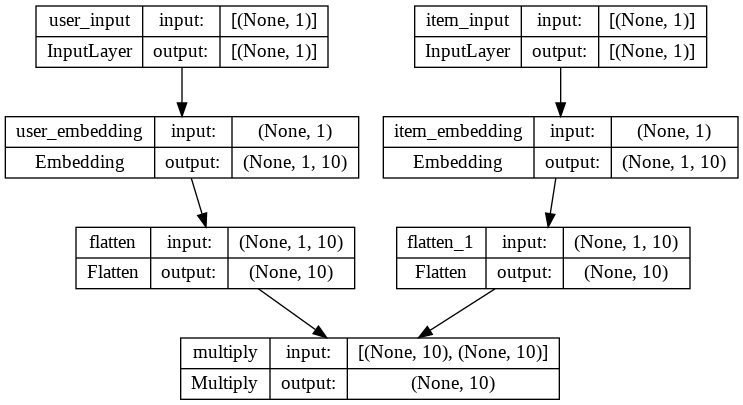

In [ ]:
model_MF = get_MF_model(num_users, num_items, 10)
plot_model(model_MF, show_shapes=True, show_layer_names=True)

<br><br><br><br><br><br>
#### Multi Layer Perceptron (MLP)

In [ ]:
model_MLP = None

In [ ]:
def get_MLP_model(num_users, num_items, latent_dim, regs=[[0,0],0,0], layers = [20,10]):
    assert len(layers) + 1 == len(regs)
    # input layer
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Latent dimension layer
    MLP_Embedding_User = Embedding(input_dim=num_users, output_dim=latent_dim,
                                   name='user_embedding', embeddings_regularizer=l2(regs[0][0]),
                                   input_length=1, embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    
    MLP_Embedding_Item = Embedding(input_dim=num_items, output_dim=latent_dim,
                                   name='item_embedding', embeddings_regularizer=l2(regs[0][1]),
                                   input_length=1, embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    
    # Flatten embedding vector
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # Concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])
    
    # MLP layers
    for idx in range(len(layers)):
        layer = Dense(layers[idx], kernel_regularizer = l2(regs[idx+1]),
                      activation='relu', name='layer%d' %idx)
        vector = layer(vector)

    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform',
                       name='prediction')(vector)

    # model
    model = Model(inputs=[user_input, item_input], outputs=prediction,name='MLP')
    return model

Model's architecture:

In [ ]:
# display/print the model architecture

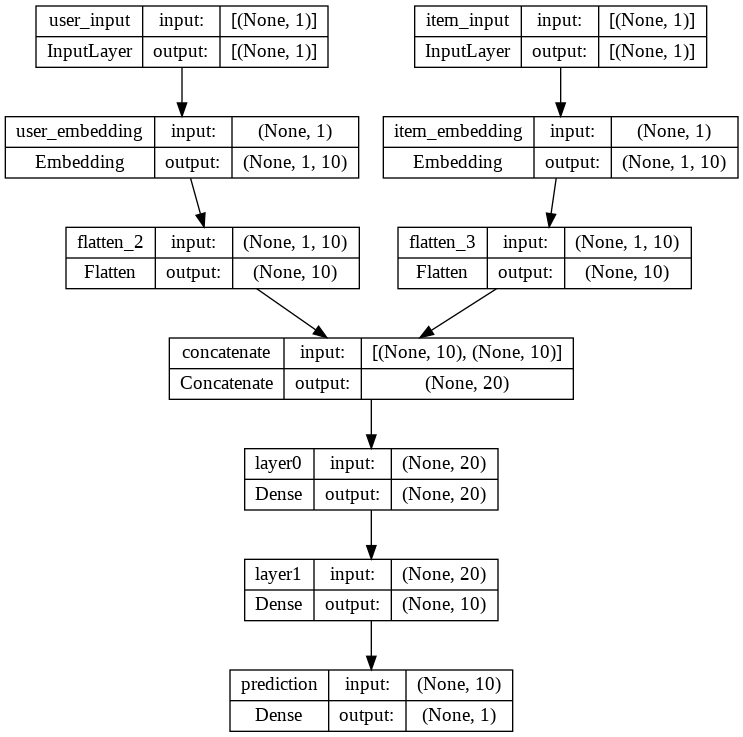

In [ ]:
model_MLP = get_MLP_model(num_users, num_items, 10)
plot_model(model_MLP, show_shapes=True, show_layer_names=True)

<br><br><br><br><br><br>
####Generalized Matrix Factorization (GMF)

In [ ]:
model_GMF = None

In [ ]:
def get_GMF_model(num_users, num_items, latent_dim, regs=[[0,0]]):
    # Generalized Matrix Factorization
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')
    
    # Latent dimension layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim=latent_dim,
                                  name='user_embedding', embeddings_regularizer=l2(regs[0][0]),
                                  input_length=1, embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim=latent_dim,
                                  name='item_embedding', embeddings_regularizer=l2(regs[0][1]),
                                  input_length=1, embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    
    # Flatten embedding vector
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform',
                       name='prediction')(predict_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction, name='GMF')
    return model

Model's architecture:

In [ ]:
# display/print the model architecture

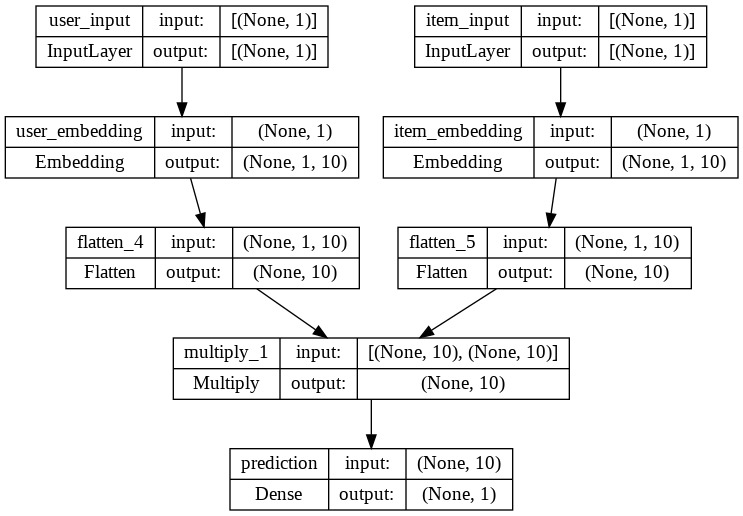

In [ ]:
model_GMF = get_GMF_model(num_users, num_items, 10)
plot_model(model_GMF, show_shapes=True, show_layer_names=True)

<br><br><br><br><br><br>
#### NeuroMatrixFactorization (NMF)


In [ ]:
model_NMF = None

In [ ]:
def get_NMF_model(num_users, num_items, latent_dim_GMF, latent_dim_MLP,
                  reg_GMF=[[0,0]], regs_MLP=[[0,0],0,0], layers=[20,10],
                  final_ac='sigmoid', model_name='NMF'):

    # input
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')
    
    
    # MF - Latent layer
    MF_Embedding_User = Embedding(input_dim=num_users, output_dim=latent_dim_GMF,
                                  name='MF_user_embedding', embeddings_regularizer=l2(reg_GMF[0][0]),
                                  input_length=1, embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    MF_Embedding_Item = Embedding(input_dim=num_items, output_dim=latent_dim_GMF,
                                  name='MF_item_embedding', embeddings_regularizer=l2(reg_GMF[0][1]),
                                  input_length=1, embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    
    # MF - Flatten
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # MF - Multiply
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])
    
    # MLP - Latent layer
    MLP_Embedding_User = Embedding(input_dim=num_users, output_dim=latent_dim_MLP,
                                   name='MLP_user_embedding', embeddings_regularizer=l2(regs_MLP[0][0]),
                                   input_length=1, embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    MLP_Embedding_Item = Embedding(input_dim=num_items, output_dim=latent_dim_MLP,
                                   name='MLP_item_embedding', embeddings_regularizer=l2(regs_MLP[0][1]),
                                   input_length=1, embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    
    # MLP - Flatten
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # MLP - Concatenate
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    
    # MLP - fully connected layers
    for idx in range(len(layers)):
        layer =  Dense(layers[idx], kernel_regularizer=l2(regs_MLP[idx+1]),
                       activation='tanh', name='layer%d' %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation=final_ac, kernel_initializer='lecun_uniform',
                       name="prediction")(predict_vector)    
    
    # model
    model = Model(inputs=[user_input, item_input], outputs=prediction,name=model_name)
    return model

Model's architecture:

In [ ]:
# display/print the model architecture

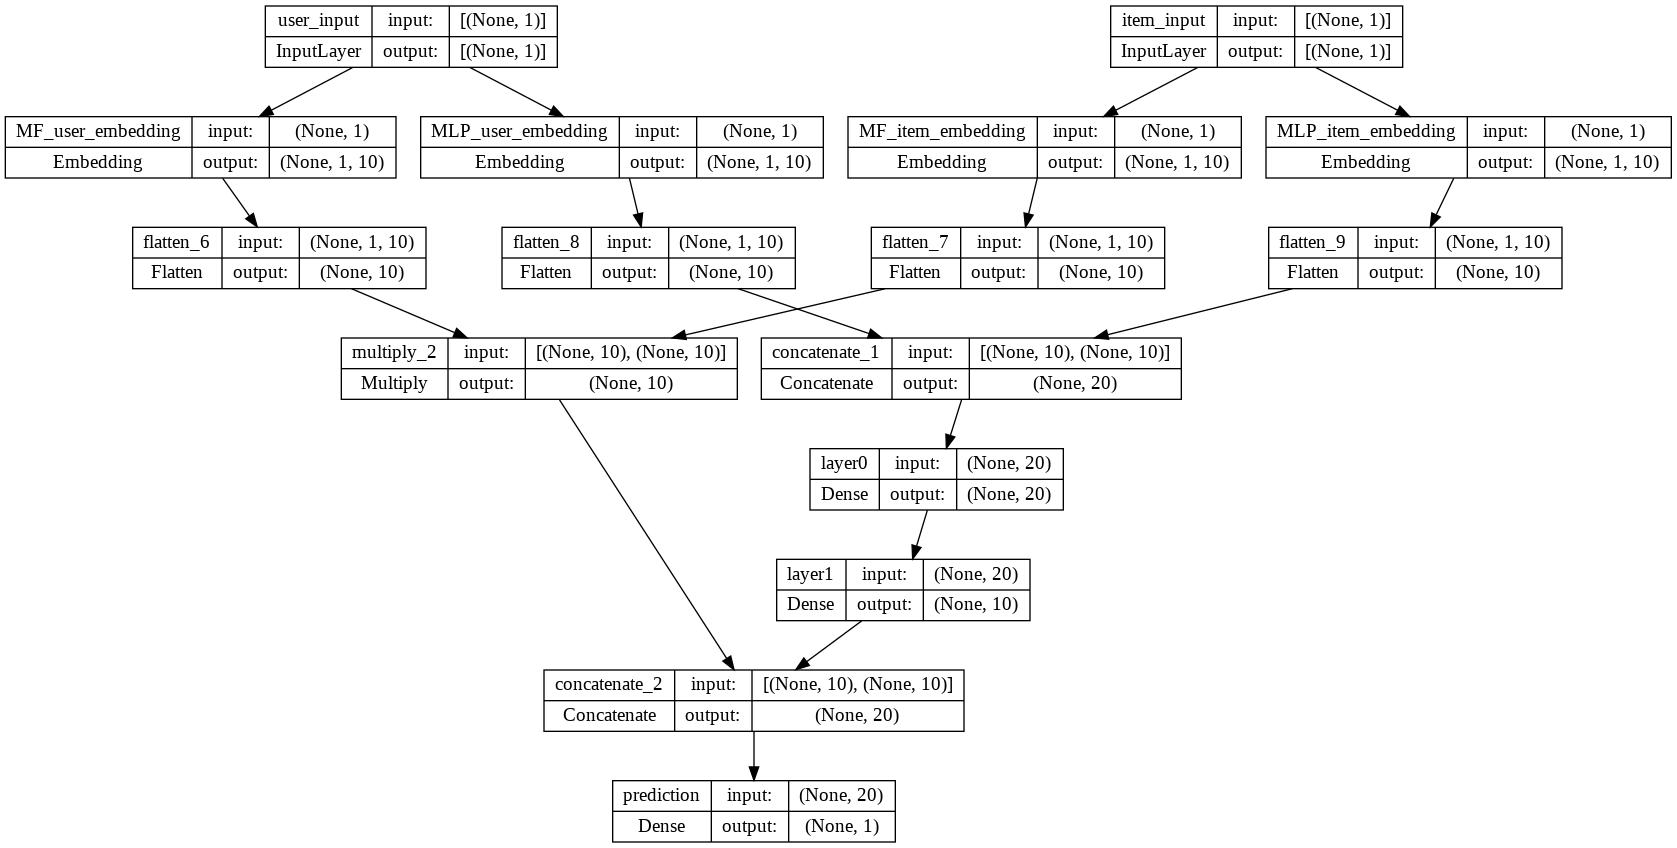

In [ ]:
model_NMF = get_NMF_model(num_users, num_items, 10, 10)
plot_model(model_NMF, show_shapes=True, show_layer_names=True)

<br><br><br><br><br><br>

## b. Train and evaluate the recommendations accuracy of the models: 
- MF
- GMF
- MLP
- NMF

Compare the `LogLoss` and recommendations accuracy using `NDCG` and `MRR` metrics with cutoff values of 5 and 10.   
Discuss the comparison. 

**Metrics:**
- HitRatio
- nDCG
- MRR

In [ ]:
# Use your own metrics implementation OR use external packages for the metrics.
# If you are using external packages make sure they work properly. 
# A lot of the packages available does not work as you would expect.

In [ ]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

def getMRR(ranklist, gtItem):
    num_movies_tested = 0
    for item in ranklist:
        num_movies_tested += 1
        if item == gtItem:
            mrr = 1 / num_movies_tested
            return mrr
    return 0

**Evaluation:**

In [ ]:
# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs, mrrs = [],[],[]
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        mrrs = [r[2] for r in res]
        return np.mean(hits), np.mean(ndcgs), np.mean(mrrs)
    # Single thread
    for idx in tqdm(range(len(_testRatings))):
        (hr,ndcg,mrr) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)  
        mrrs.append(mrr)    
    return np.mean(hits), np.mean(ndcgs), np.mean(mrrs)

def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)

    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict([users, np.array(items)],
                                 batch_size=batch_size, verbose=0)

    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = list(predictions[i])
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    mrr = getMRR(ranklist, gtItem)
    return (hr, ndcg, mrr)

**HyperParams:**

In [ ]:
# the choosen hyperparams will effect your models & your grade 

# Different values will be used during hyperparams search in training

num_negatives = 4 
top_5k = 5
top_10k = 10 
evaluation_threads = 1
epochs = 20
learning_rate = 5e-4
latent_dim = 16
batch_size = 256

optimizer_algorithm=Adam(lr=learning_rate)
loss_function = 'binary_crossentropy'

<br><br>
Create train data:

In [ ]:
data = []
labels = []

for i in range(epochs):
    user_data, item_data, label = get_train_instances(train, num_negatives)
    data.append([np.array(user_data), np.array(item_data)])
    labels.append(np.array(label))

<br><br>
train & eval:
- Create a training function 
- Evaluate the models trained and save the results accordingly 

In [ ]:
results = pd.DataFrame(columns = ['model', 'topk','metric','score']) # as suggested to us
val_results = pd.DataFrame(columns = ['model', 'topk','metric','score'])

In [ ]:
def model_train(model):
  print(f'train:')
  loss_history = []
  val_loss_history = []
  start_time = time()
  prev_val_loss = float('inf')
  is_overfit = 0

  model.compile(optimizer=optimizer_algorithm, loss=loss_function)

  for i in tqdm(range(epochs)):
      if is_overfit >= 3:
          print(f'overfit: stopped training after {i} epochs\n')
          break

      hist = model.fit(data[i], labels[i], batch_size=batch_size, epochs=1, verbose=0, shuffle=True, validation_split=0.2)
      loss_history.extend(hist.history['loss'])
      val_loss_history.extend(hist.history['val_loss'])

      if val_loss_history[-1] >= prev_val_loss:
        is_overfit += 1
      prev_val_loss = val_loss_history[-1]
  
  results.loc[len(results)] = model.name, 0, 'TIME', (time()-start_time)/epochs/60
  results.loc[len(results)] = model.name, 0, 'LOSS', loss_history

  val_results.loc[len(val_results)] = model.name, 0, 'VAL_LOSS', val_loss_history

  return model

def model_eval(model):
  top_ks = [top_5k, top_10k]

  for top_k in top_ks:
    print(f'evaluate with topk={top_k}:')
    hr, ndcg, mrr = evaluate_model(model, testRatings, testNegatives, top_k, evaluation_threads)
    results.loc[len(results)] = model.name, top_k, 'HR', hr
    results.loc[len(results)] = model.name, top_k, 'NDCG' ,ndcg
    results.loc[len(results)] = model.name, top_k, 'MRR' ,mrr

In [ ]:
models = [model_MF, model_GMF, model_MLP, model_NMF]

for model in models:
  print(f'\n##### Train & Evaluate {model.name} #####\n')
  trained_model = model_train(model)
  model_eval(trained_model)


##### Train & Evaluate MF #####

train:


  0%|          | 0/20 [00:00<?, ?it/s]

overfit: stopped training after 5 epochs

evaluate with topk=5:


  0%|          | 0/6040 [00:00<?, ?it/s]

evaluate with topk=10:


  0%|          | 0/6040 [00:00<?, ?it/s]


##### Train & Evaluate GMF #####

train:


  0%|          | 0/20 [00:00<?, ?it/s]

overfit: stopped training after 4 epochs

evaluate with topk=5:


  0%|          | 0/6040 [00:00<?, ?it/s]

evaluate with topk=10:


  0%|          | 0/6040 [00:00<?, ?it/s]


##### Train & Evaluate MLP #####

train:


  0%|          | 0/20 [00:00<?, ?it/s]

overfit: stopped training after 4 epochs

evaluate with topk=5:


  0%|          | 0/6040 [00:00<?, ?it/s]

evaluate with topk=10:


  0%|          | 0/6040 [00:00<?, ?it/s]


##### Train & Evaluate NMF #####

train:


  0%|          | 0/20 [00:00<?, ?it/s]

overfit: stopped training after 4 epochs

evaluate with topk=5:


  0%|          | 0/6040 [00:00<?, ?it/s]

evaluate with topk=10:


  0%|          | 0/6040 [00:00<?, ?it/s]

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
All Results:

In [ ]:
results

,model,topk,metric,score
0,MF,0,TIME,0.165514
1,MF,0,LOSS,"[1.8878748416900635, 1.7246161699295044, 1.719..."
2,MF,5,HR,0.221689
3,MF,5,NDCG,0.152
4,MF,5,MRR,0.129109
5,MF,10,HR,0.318543
6,MF,10,NDCG,0.183345
7,MF,10,MRR,0.142059
8,GMF,0,TIME,0.131983
9,GMF,0,LOSS,"[0.3754287362098694, 0.3382204473018646, 0.308..."


<br><br><br><br>
**Train & Validation Loss:**

Make sure you did not overfit.
In case you did, fix that by adding early-stopping, regularization, etc.

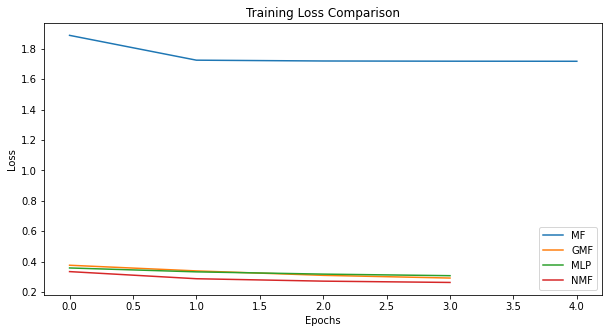

In [ ]:
plt.figure(figsize=(10,5))

for i, x in enumerate(results.loc[results['metric'] == 'LOSS']['score']):
  plt.plot(x)

plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(results.loc[results['metric'] == 'LOSS']['model'])
plt.show()

When comparing the NMF, GMF and MLP to the classic matrix factorization (MF) model, it appears that the former generally have a lower training loss. This could be due to the fact that these models are using a final prediction layer as opposed to a simple dot product, which is more modern and incorporate recent advancements in the field. Additionally, when comparing these models (NMF, GMF and MLP) to one another, it appears that they tend to yield similar training loss values.

In [ ]:
train_results = results[(results['metric'] == 'LOSS')]

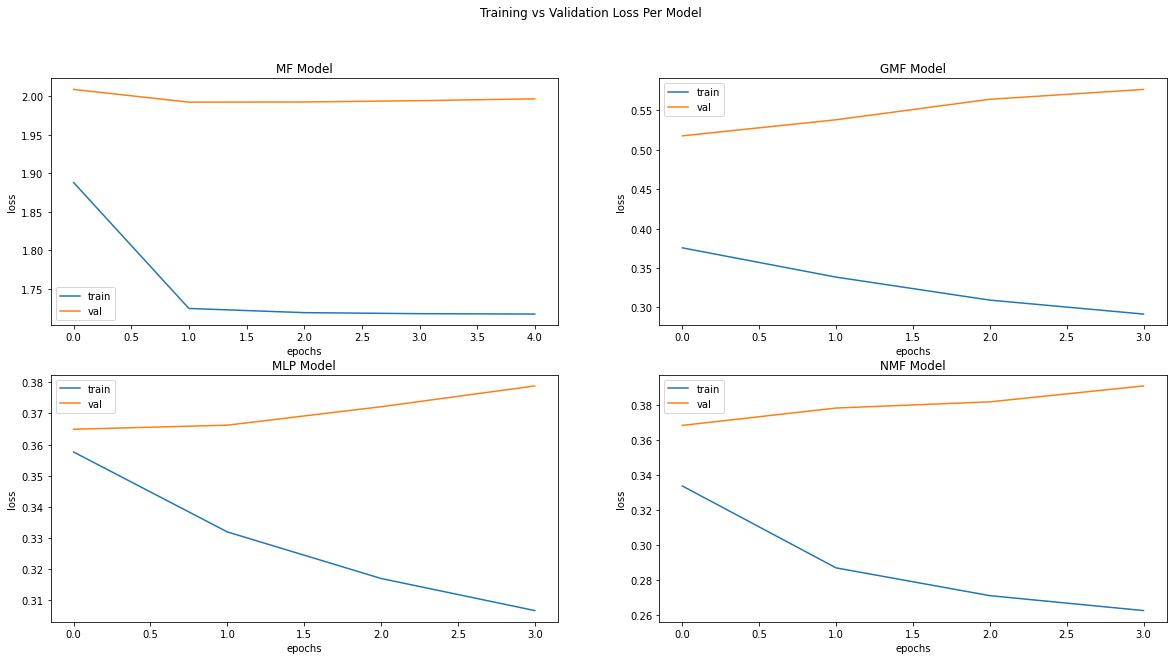

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(20)

axs[0, 0].plot(list(train_results.loc[train_results['model'] == 'MF']['score'])[0], label='train')
axs[0, 0].plot(list(val_results.loc[val_results['model'] == 'MF']['score'])[0], label='val')
axs[0, 0].set_title('MF Model')
axs[0, 0].legend()

axs[0, 1].plot(list(train_results.loc[train_results['model'] == 'GMF']['score'])[0], label='train')
axs[0, 1].plot(list(val_results.loc[val_results['model'] == 'GMF']['score'])[0], label='val')
axs[0, 1].set_title('GMF Model')
axs[0, 1].legend()

axs[1, 0].plot(list(train_results.loc[train_results['model'] == 'MLP']['score'])[0], label='train')
axs[1, 0].plot(list(val_results.loc[val_results['model'] == 'MLP']['score'])[0], label='val')
axs[1, 0].set_title('MLP Model')
axs[1, 0].legend()

axs[1, 1].plot(list(train_results.loc[train_results['model'] == 'NMF']['score'])[0], label='train')
axs[1, 1].plot(list(val_results.loc[val_results['model'] == 'NMF']['score'])[0], label='val')
axs[1, 1].set_title('NMF Model')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='loss')

fig.suptitle("Training vs Validation Loss Per Model")
plt.show()

As observed, in all the models, the validation loss is consistently higher than the training loss. This is a logical outcome, as the model is expected to perform better on the data it has already seen during training. Additionally, to prevent overfitting, early stopping was implemented, where the training process was halted when the model displayed signs of overfitting to the validation data.

Training Time:

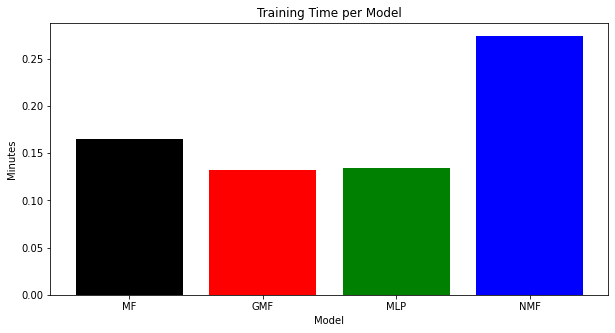

In [ ]:
plt.figure(figsize=(10,5))

plt.bar('model', 'score', data=results[results['metric']=='TIME'], color=['black', 'red', 'green', 'blue']);
plt.title("Training Time per Model")
plt.xlabel('Model')
plt.ylabel('Minutes')
plt.show()

The NMF training time was longer, which could be logic, since it is more complicated, combining both the MLP and the GMF models.

Metric Evaluation:

In [ ]:
results_topk=results[(results['topk']!=0)]

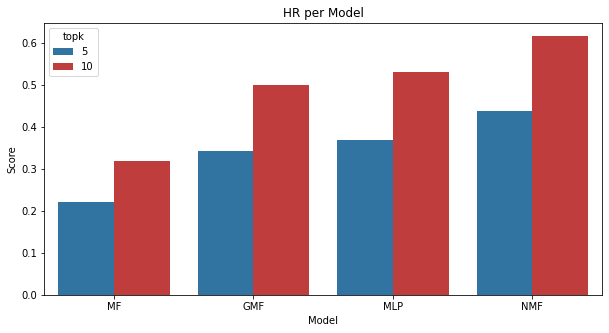

In [ ]:
plt.figure(figsize=(10,5))
colors = ['tab:blue', 'tab:red']
sns.barplot(data=results_topk[(results_topk['metric']=='HR')], x='model', y='score', hue=results_topk['topk'] , palette=colors)
plt.title("HR per Model")
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

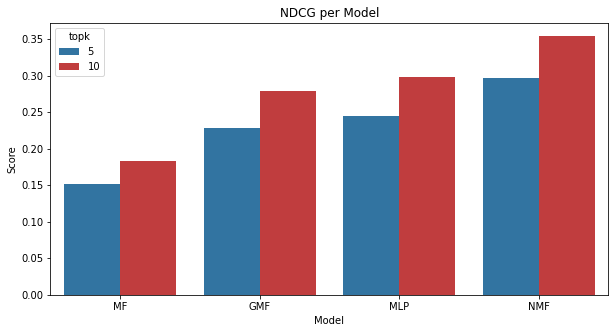

In [ ]:
plt.figure(figsize=(10,5))
colors = ['tab:blue', 'tab:red']
sns.barplot(data=results_topk[(results_topk['metric']=='NDCG')], x='model', y='score', hue=results_topk['topk'], palette=colors)
plt.title("NDCG per Model")
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

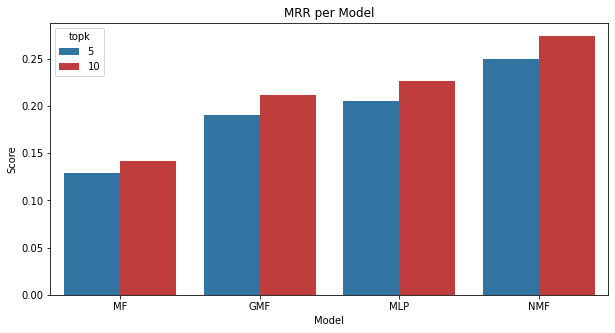

In [ ]:
plt.figure(figsize=(10,5))
colors = ['tab:blue', 'tab:red']
sns.barplot(data=results_topk[(results_topk['metric']=='MRR')], x='model', y='score', hue=results_topk['topk'], palette=colors)
plt.title("MRR per Model")
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

As we can see, the GMF, MLP and NMF models achieved better results than the classic MF model in all metrices, which is aligned with the training loss results. Also, it seems that NMF is the leading model, which is logic, since it is more complicated, combining both the MLP and the GMF models.

<br><br><br><br>
<br><br><br><br>

**c. How do the values of MRR and NDCG differ between your current model and the results you got in the previous exercises which implemented the explicit recommendation approach? What are the differences in preparing the dataset for evaluation?**

In this homework, the approach taken was different from previous assignments as more advanced deep learning algorithms were utilized. Additionally, previous assignments dealt with explicit rating and a regression problem, whereas this assignment dealt with implicit ratings and a classification problem. As a result, comparing the results of this assignment to previous ones may not be entirely valid.<br><br>The evaluation results in terms of MRR and NDCG were generally higher in previous assignments, which suggests that classical approaches should also be considered before implementing more sophisticated deep learning models. These classical approaches could also be used as baselines for comparison and provide a benchmark against the more advanced deep learning algorithms results.<br><br>It is also worth mentioning that the evaluation in this assignment was significantly more time-consuming due to the inclusion of testNegatives, which made it challenging to perform proper hyperparameter tuning through grid search. In contrast, the evaluation process in previous assignments was quicker and more manageable. That's why in this assignment we've used the parameters values from the paper as mentioned in question 2a.

**d. How will you measure item similarity using the NeuMF model?**

In order to measure item similarity using the Neural Matrix Factorization (NMF) model, we can utilize the embedding layers to compute vector similarities, such as Cosine similarity or Pearson correlation, between items. This approach takes advantage of the fact that the NMF model maps items to a low-dimensional latent space, where the similarity between items can be easily measured.<br><br>Additionally, the NMF model combine two different embedding layers, one from the Matrix Factorization (MF) component and one from the Multi-Layer Perceptron (MLP) component. This presents an opportunity to experiment with different ways of combining the embeddings from the two layers (such as: dot product, mean, sum, etc.) in order to determine the best method for measuring item similarity.


## Question 3: Loss Function 
<br><br>

#### a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.    

Select one of the models you implemented in question 2 and change the loss function to a `Mean Squared Error` and the activation function of the last layer to `RELU`.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.

In [ ]:
loss_function = 'mean_squared_error'
model_name = 'NMF_mse_relu'
model_NMF_mse_relu = get_NMF_model(num_users, num_items, 10, 10, final_ac='relu', model_name=model_name)

models = [model_NMF_mse_relu]

for model in models:
  print(f'\n##### Train & Evaluate {model.name} #####\n')
  trained_model = model_train(model)
  model_eval(trained_model)


##### Train & Evaluate NMF_mse_relu #####

train:


  0%|          | 0/20 [00:00<?, ?it/s]

overfit: stopped training after 4 epochs

evaluate with topk=5:


  0%|          | 0/6040 [00:00<?, ?it/s]

evaluate with topk=10:


  0%|          | 0/6040 [00:00<?, ?it/s]

<br><br><br><br>
<br><br><br><br>
NMFs Results:

In [ ]:
nmf_results = results[results.model.str.startswith('NMF')]
nmf_results

,model,topk,metric,score
24,NMF,0,TIME,0.274213
25,NMF,0,LOSS,"[0.3336332142353058, 0.28673693537712097, 0.27..."
26,NMF,5,HR,0.436921
27,NMF,5,NDCG,0.296306
28,NMF,5,MRR,0.250138
29,NMF,10,HR,0.616556
30,NMF,10,NDCG,0.354428
31,NMF,10,MRR,0.274142
32,NMF_mse_relu,0,TIME,0.274187
33,NMF_mse_relu,0,LOSS,"[0.10172121226787567, 0.08618280291557312, 0.0..."


<br><br><br>
<br><br><br>

Train & Validation Loss:

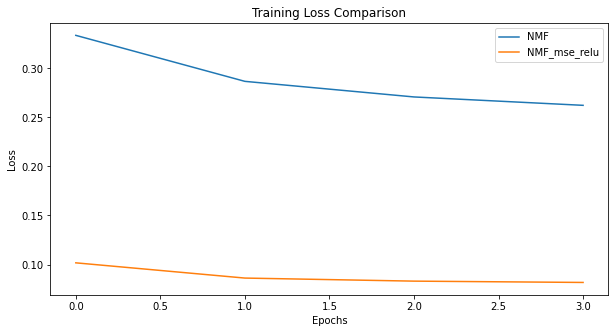

In [ ]:
plt.figure(figsize=(10,5))

for i, x in enumerate(nmf_results.loc[results['metric'] == 'LOSS']['score']):
  plt.plot(x)

plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(nmf_results.loc[nmf_results['metric'] == 'LOSS']['model'])
plt.show()

In [ ]:
train_results = results.loc[results['metric'] == 'LOSS']

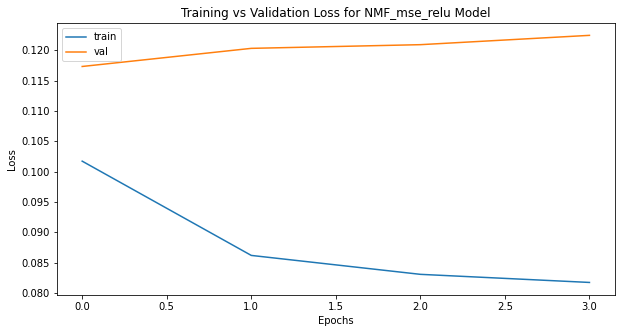

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(list(train_results.loc[train_results['model'] == 'NMF_mse_relu']['score'])[0], label='train')
plt.plot(list(val_results.loc[val_results['model'] == 'NMF_mse_relu']['score'])[0], label='val')

plt.title("Training vs Validation Loss for NMF_mse_relu Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

<br><br><br>
Training Time:

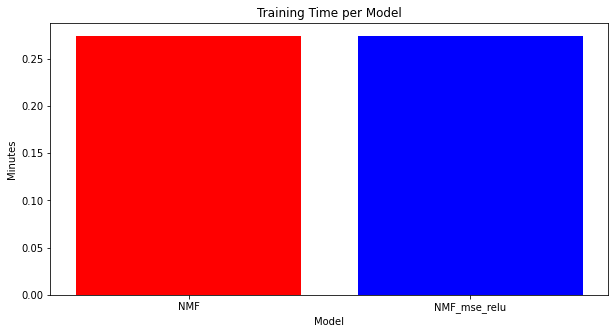

In [ ]:
plt.figure(figsize=(10,5))

plt.bar('model', 'score', data=nmf_results[nmf_results['metric']=='TIME'], color=['red', 'blue']);
plt.title("Training Time per Model")
plt.xlabel('Model')
plt.ylabel('Minutes')
plt.show()

Both models took similar amount of time, which is logic since we are using similar models.

<br><br><br>
Metric Evaluation:

In [ ]:
nmf_results_topk=nmf_results[(nmf_results['topk']!=0)]

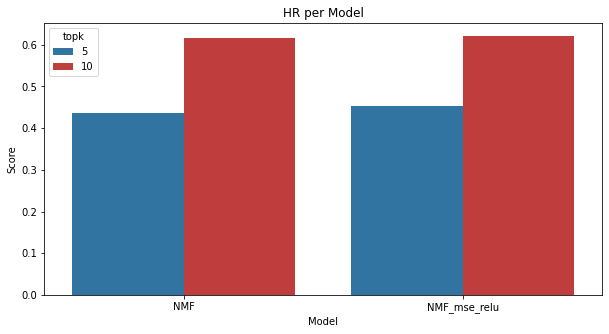

In [ ]:
plt.figure(figsize=(10,5))
colors = ['tab:blue', 'tab:red']
sns.barplot(data=nmf_results_topk[(nmf_results_topk['metric']=='HR')], x='model', y='score', hue=nmf_results_topk['topk'], palette=colors)
plt.title("HR per Model")
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

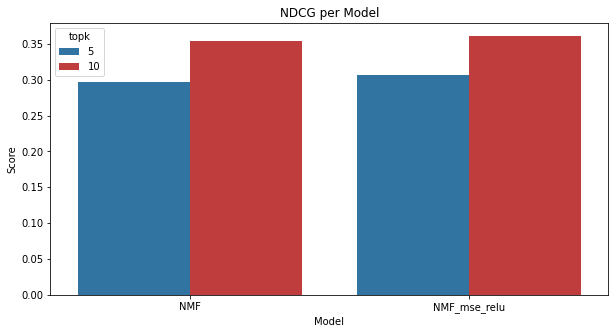

In [ ]:
plt.figure(figsize=(10,5))
colors = ['tab:blue', 'tab:red']
sns.barplot(data=nmf_results_topk[(nmf_results_topk['metric']=='NDCG')], x='model', y='score', hue=nmf_results_topk['topk'], palette=colors)
plt.title("NDCG per Model")
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

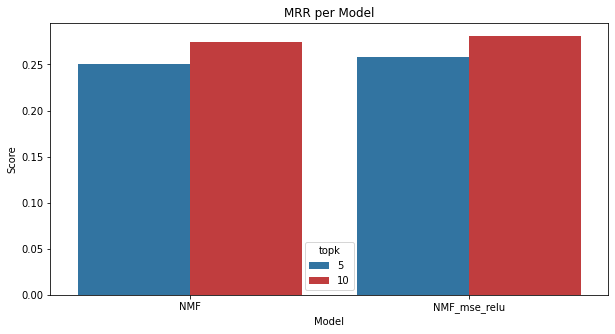

In [ ]:
plt.figure(figsize=(10,5))
colors = ['tab:blue', 'tab:red']
sns.barplot(data=nmf_results_topk[(nmf_results_topk['metric']=='MRR')], x='model', y='score', hue=nmf_results_topk['topk'], palette=colors)
plt.title("MRR per Model")
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

<br><br><br><br>
**Conclusions:**

    

Let's first discuss what is the difference between the given activation and loss functions.<br><br>Activation Functions: The ReLU activation function is generally considered to be a better choice than the Sigmoid function for several reasons. Firstly, The ReLU function does not saturate (in the ! > 0 region) and can alleviate the vanishing gradient problem in deep networks. This is a known problem for the Sigmoid function which saturates for large positive or negative inputs. Additionally, the ReLU function is computationally efficient, and can improve the convergence rate of the network during training, thus reducing the training time, while Sigmoid is using the exp() function which is computationally expensive.<br><br>Loss Functions: Binary Cross-Entropy (BCE) is more suited for probability distribution-based predictions, as it is directly related to the log-likelihood of a Bernoulli distribution. One of the main advantages of using BCE as a loss function is that it is well-suited for problems where the data is highly imbalanced, such as in cases where the number of negative samples is much larger than the number of positive samples. Also, BCE is more robust to outliers compared to Mean Squared Error (MSE) since the latter is sensitive to large errors.<br><br>As we can see from the results the preformance of the original NMF model is similar to the NMF_mse_relu model, which suggest that the combination between the BCE loss function and the sigmoid activation function is similar to the MSE loss functions and the ReLU activation function for this task, even though RELU is a generally a better activation function. Generally, BCE is indeed a good choice when working with sigmoid (or softmax) activation functions in the output layer of a neural network, which produce probability-like outputs. Thats was probably the logic behind using BCE with the sigmoid function, which eventually leads to similar results as with using the ReLU activation function


Good Luck :)